In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import scanpy as sc
import anndata as an
from textwrap import fill
import scipy
from collections import Counter
import sklearn
import gget

from importlib import reload
import utils as ut
import plotting as plt2

In [2]:
sc.settings.verbosity = 4

# Load iHSC data

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

ihsc_data = sc.read_h5ad(fpath)
ihsc_data.var_names = ihsc_data.var['gene_name'].values
sc.pp.filter_genes(ihsc_data, min_cells=2) 
sc.logging.print_memory_usage()

ihsc_data

Memory usage: current 4.62 GB, difference +4.62 GB


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Load HSC data

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/weng_2024/scanpy_objects/young2_HSC.h5ad"

hsc_data = sc.read_h5ad(fpath)
sc.pp.filter_genes(hsc_data, min_cells=2) 
sc.logging.print_memory_usage()

hsc_data

filtered out 14612 genes that are detected in less than 2 cells
Memory usage: current 4.94 GB, difference +0.31 GB


AnnData object with n_obs × n_vars = 3703 × 21989
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup'
    var: 'name', 'gene_name', 'n_cells'
    obsm: 'X_lsi', 'X_pca', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'raw_counts'

# Load BJ data

In [5]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.h5ad"

bj_data = sc.read_h5ad(fpath)
bj_data = bj_data[bj_data.obs['dataset'] == 'chen_2015', :].copy()
bj_data.layers['raw_counts'] = bj_data.X.copy()
sc.pp.filter_genes(bj_data, min_cells=2) 

bj_data.obs['cell_type'] = "BJ"
bj_data.var['gene_name'] = bj_data.var.index.copy()

bj_data

filtered out 3894 genes that are detected in less than 2 cells


AnnData object with n_obs × n_vars = 18 × 15499
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control', 'cell_type'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id', 'n_cells', 'gene_name'
    layers: 'raw_counts'

# Get gene list

In [6]:
def get_common_genes(gene_sets, min_count=2):
    """
    Finds genes that occur in at least 'min_count' of the gene sets.

    Args:
        gene_sets: A list of lists, where each inner list represents a set of genes.
        min_count: The minimum number of gene sets a gene must appear in to be considered common (default is 2).

    Returns:
        A list of common genes.
    """

    print("Analyzing gene sets...")

    # Flatten the list of gene sets into a single list
    all_genes = [gene for gene_set in gene_sets for gene in gene_set]

    # Count the occurrences of each gene
    gene_counts = Counter(all_genes)

    # Filter genes based on the minimum count threshold
    common_genes = [gene for gene, count in gene_counts.items() if count >= min_count]

    print(f"Found {len(common_genes)} common genes across at least {min_count} gene sets.")

    return common_genes
    
common_genes = get_common_genes(
    [bj_data.var_names,
    hsc_data.var_names,
    ihsc_data.var_names,]
)

Analyzing gene sets...
Found 15887 common genes across at least 2 gene sets.


# Reprocess

In [7]:
def reprocess(adata, gene_list):
    """A function to reprocess an adata object """
    keep_genes = [x for x in adata.var_names if x in gene_list]
    adata = adata[:, keep_genes].copy()
    
    adata.X = adata.layers['raw_counts'].copy()
    
    sc.pp.normalize_total(
            adata, 
            target_sum=1e6,
            key_added='norm_factor',
    )
    
    adata.layers["cpm"] = adata.X.copy()
    sc.pp.log1p(adata)
    adata.layers["log_cpm"] = adata.X.copy()
    return adata
    
    
test = reprocess(ihsc_data, common_genes)
test    

normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 8563 × 12855
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'norm_factor'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts', 'cpm', 'log_cpm'
    obsp: 'connectivities', 'd

# iHSC to FIB

Analyzing gene sets...
Found 12050 common genes across at least 2 gene sets.
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
X.shape=(8563, 18)


Text(0.5, 1.0, 'iHSC to BJ')

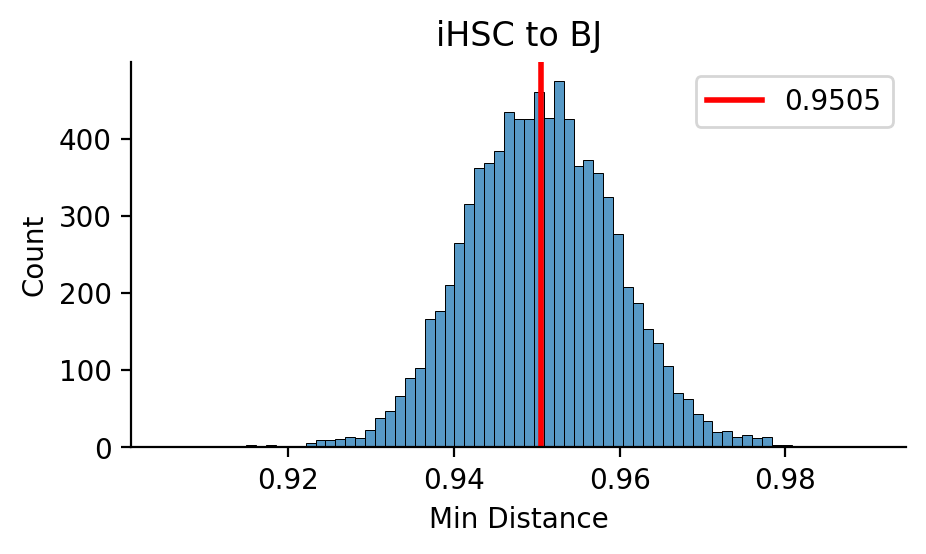

In [8]:
def get_distance(A, B, metric='cosine', gene_list=None, layer='cpm'):
    """A function to compute distances between two adata objects """
    if gene_list is None:
        A = A.to_df(layer=layer)
        B = B.to_df(layer=layer)
    else:
        A = A[:, gene_list].to_df(layer=layer)
        B = B[:, gene_list].to_df(layer=layer)
        
    X = cdist(
        A, B, 
        metric=metric,
    )

    return pd.DataFrame(
        X, 
        index=A.index,
        columns=B.index,
    )

common_genes = get_common_genes(
    [bj_data.var_names,
    ihsc_data.var_names,],
     min_count=2
)

A = reprocess(ihsc_data, common_genes)
B = reprocess(bj_data, common_genes)

metric = 'cosine'
    
X = get_distance(A, B, metric=metric)
print(f"{X.shape=}")


def plot_min_distance_histogram(X):
    """
    Plots a histogram of the minimum distances along axis 1 of the input data `X`.

    Args:
        X: A NumPy array or Pandas DataFrame representing the data.

    Returns:
        None (displays the plot)
    """

    min_dist = X.min(axis=1)

    sns.histplot(
        x=min_dist, 
    )

    plt.axvline(
        min_dist.mean(), 
        c='r', 
        lw=2, 
        label=f"{min_dist.mean():.4f}"
    )

    plt.xlabel('Min Distance')

    sns.despine()
    plt.legend()
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5
plot_min_distance_histogram(X)
plt.title('iHSC to BJ')

# iHSC to HSC

Analyzing gene sets...
Found 11456 common genes across at least 2 gene sets.
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
Y.shape=(8563, 3703)


Text(0.5, 1.0, 'iHSC to HSC')

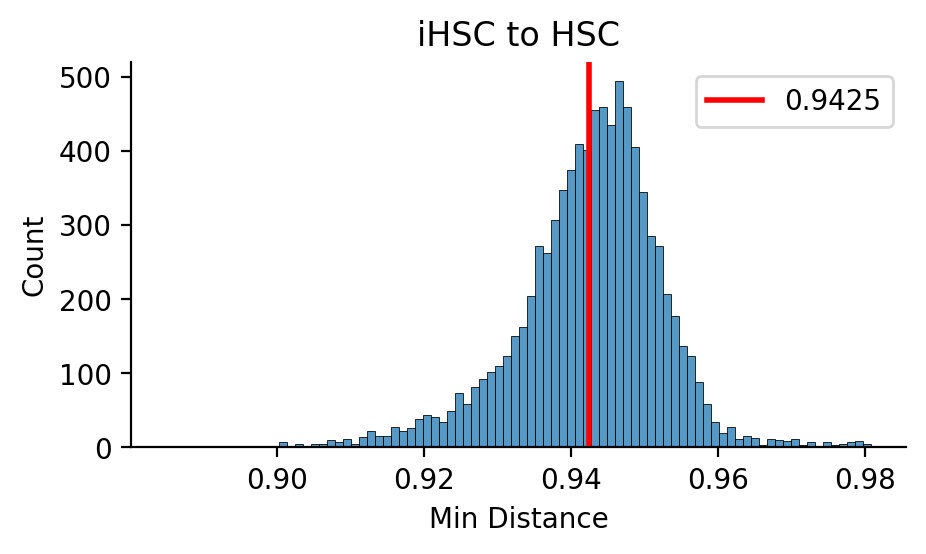

In [9]:
common_genes = get_common_genes(
    [hsc_data.var_names,
    ihsc_data.var_names,],
     min_count=2
)

A = reprocess(ihsc_data, common_genes)
B = reprocess(hsc_data, common_genes)

metric = 'cosine'
    
Y = get_distance(A, B, metric=metric)
print(f"{Y.shape=}")
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5
plot_min_distance_histogram(Y)
plt.title('iHSC to HSC')

# BJ to HSC

Analyzing gene sets...
Found 13683 common genes across at least 2 gene sets.
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
Z.shape=(3703, 18)


Text(0.5, 1.0, 'HSC to BJ')

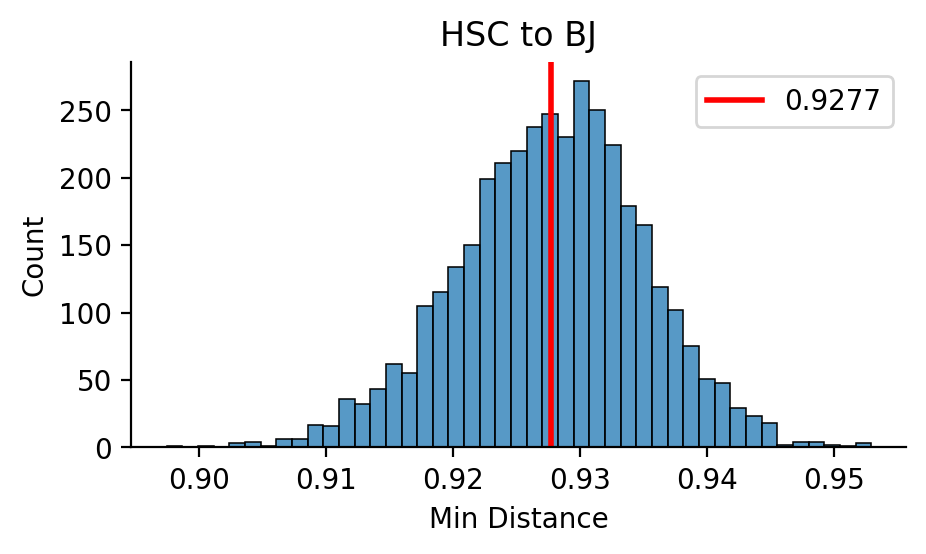

In [10]:
common_genes = get_common_genes(
    [hsc_data.var_names,
     bj_data.var_names,],
     min_count=2
)

A = reprocess(hsc_data, common_genes)
B = reprocess(bj_data, common_genes)

metric = 'cosine'
    
Z = get_distance(A, B, metric=metric)
print(f"{Z.shape=}")
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5
plot_min_distance_histogram(Z)
plt.title('HSC to BJ')

# comparison

X.shape=(8563, 18)
Y.shape=(8563, 3703)
65.1744804170748 pval=0.0


[Text(0, 0, 'BJ'), Text(1, 0, 'HSC')]

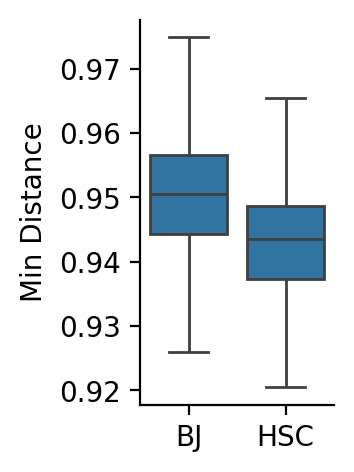

In [28]:
print(f"{X.shape=}")
print(f"{Y.shape=}")


df = pd.concat([
    X.min(axis=1),
    Y.min(axis=1),],
    axis=1,
)

df.columns = ['dist_2_fib', 'dist_2_hsc']
df = df.reset_index()


score, pval = scipy.stats.ttest_rel(
    df['dist_2_fib'], 
    df['dist_2_hsc'],
    alternative='greater',
)
print(f"{score} {pval=}")

df = pd.melt(df, id_vars='cell_id')


df.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.25, 2.5

sns.boxplot(
    data=df, 
    x='variable',
    y='value',
    showfliers=False,
)

sns.despine()
plt.ylabel('Min Distance')
plt.xlabel('')
plt.gca().set_xticklabels(['BJ', 'HSC'])


In [11]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# hand-selected genes

In [29]:
common_genes = get_common_genes(
    [bj_data.var_names,
    hsc_data.var_names,
    ihsc_data.var_names,],
    min_count=3
)

print(f"{len(common_genes)=}")

Analyzing gene sets...
Found 10651 common genes across at least 3 gene sets.
len(common_genes)=10651


In [52]:
pang = ihsc_data.uns['panglaodb']
cell_types = [
    # 'Fibroblasts',
    'Hematopoietic stem cells',
]
marker_genes = list(pang[pang['cell_type'].isin(cell_types)]['gene_name'].unique())
marker_genes = [x for x in marker_genes if x in common_genes]
print(f"{len(marker_genes)=}")

len(marker_genes)=53


In [53]:
A = reprocess(hsc_data, marker_genes)
B = reprocess(bj_data, marker_genes)
C = reprocess(ihsc_data, marker_genes)

print('done')

normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
normalizing counts per cell
    finished (0:00:00)
    and added 'norm_factor', counts per cell before normalization (adata.obs)
done


X.shape=(8563, 3703)


Text(0.5, 1.0, 'iHSC to HSC')

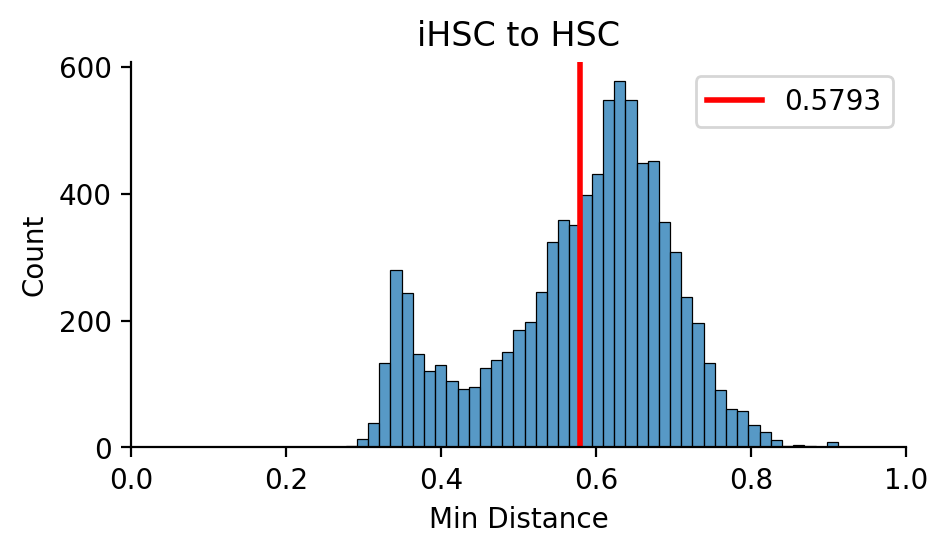

In [86]:
metric = 'cosine'
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5

X = get_distance(C, A, metric=metric)
print(f"{X.shape=}")

plot_min_distance_histogram(X)
plt.xlim([0, 1])
plt.title("iHSC to HSC")

Y.shape=(8563, 18)


Text(0.5, 1.0, 'iHSC to FB')

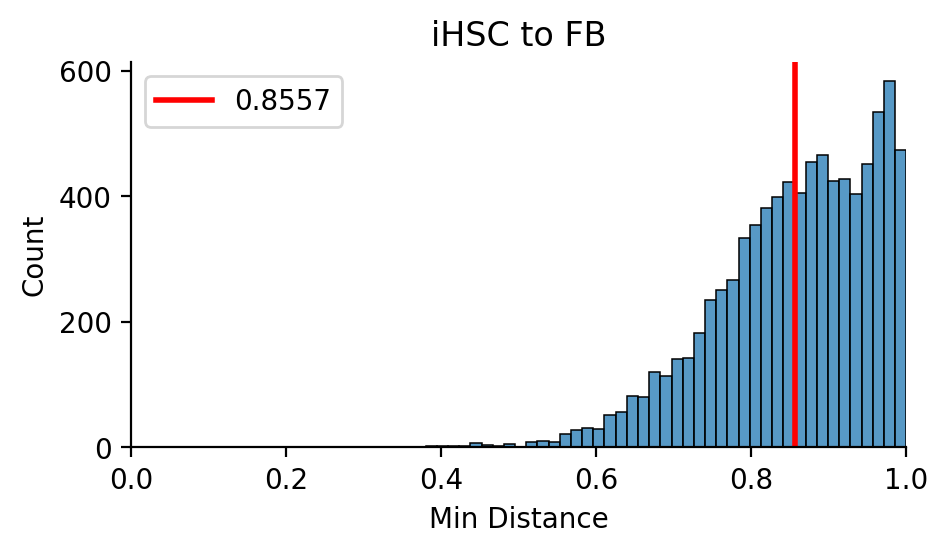

In [87]:
metric = 'cosine'
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5

Y = get_distance(C, B, metric=metric)
print(f"{Y.shape=}")

plot_min_distance_histogram(Y)
plt.xlim([0, 1])
plt.title("iHSC to FB")

Z.shape=(3703, 18)


Text(0.5, 1.0, 'FB to HSC')

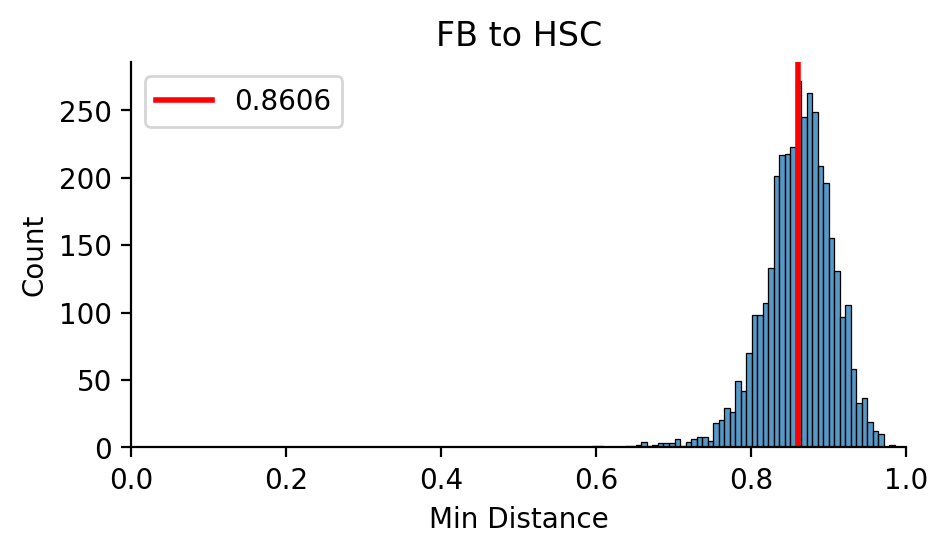

In [88]:
metric = 'cosine'
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2.5

Z = get_distance(A, B, metric=metric)
print(f"{Z.shape=}")

plot_min_distance_histogram(Z)
plt.xlim([0, 1])
plt.xlim([0, 1])
plt.title("FB to HSC")

X.shape=(8563, 3703)
Y.shape=(8563, 18)
nan pval=nan


[Text(0, 0, 'HSC'), Text(1, 0, 'BJ')]

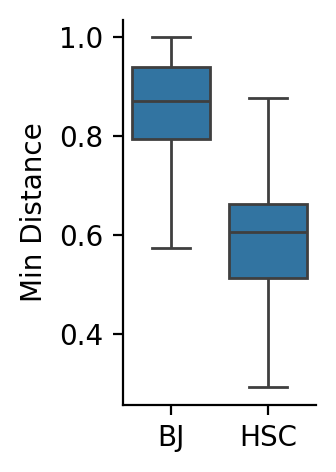

In [76]:
print(f"{X.shape=}")
print(f"{Y.shape=}")

df = pd.concat([
    X.min(axis=1),
    Y.min(axis=1),],a
    axis=1,
)

df.columns = ['dist_2_hsc', 'dist_2_fib', ]
df = df.reset_index()


score, pval = scipy.stats.ttest_rel(
    df['dist_2_fib'], 
    df['dist_2_hsc'],
    alternative='greater',
)
print(f"{score} {pval=}")

df = pd.melt(df, id_vars='cell_id')

df.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.25, 2.5

sns.boxplot(
    data=df, 
    x='variable',
    y='value',
    showfliers=False,
)

plt.gca().invert_xaxis()

sns.despine()
plt.ylabel('Min Distance')
plt.xlabel('')
plt.gca().set_xticklabels(['HSC', 'BJ'])

,cell_id,variable,value,label
0,AAACCCAAGGTTACCT,dist_2_hsc,0.395257,HSC
1,AAACCCAAGTTGAAGT,dist_2_hsc,0.618198,HSC
2,AAACCCAAGTTGTCGT,dist_2_hsc,0.664590,HSC
3,AAACCCACAGAAGCGT,dist_2_hsc,0.469268,HSC
4,AAACCCACAGGAGGTT,dist_2_hsc,0.542725,HSC


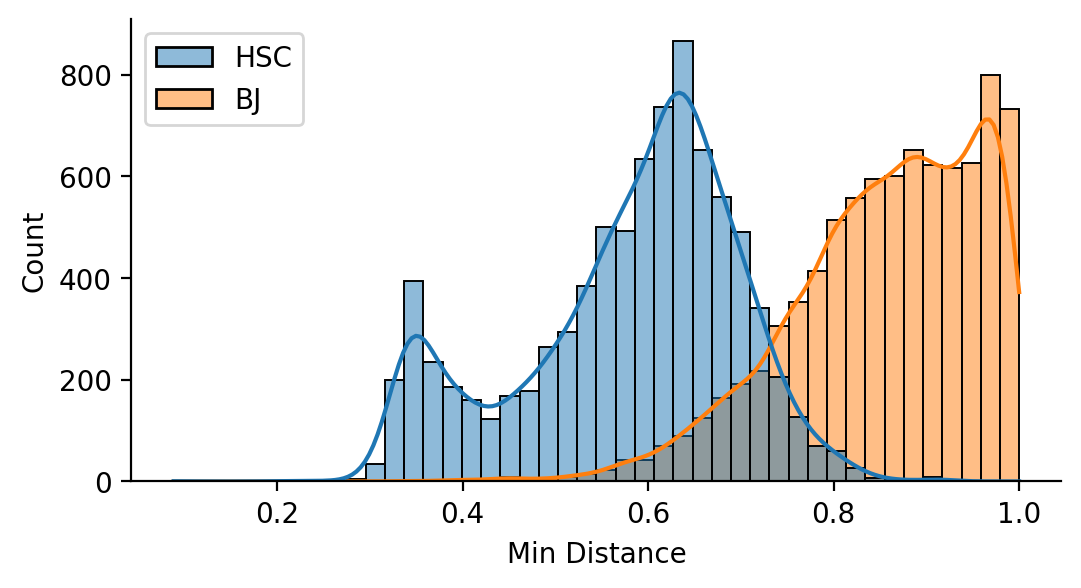

In [80]:

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

label_map = {
    'dist_2_fib' : 'BJ',
    'dist_2_hsc' : 'HSC',
}

df['label'] = df['variable'].map(label_map)

sns.histplot(
    data=df, 
    x='value',
    hue='label',
    kde=True,
)

plt.xlabel('Min Distance')

sns.despine()
sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
)

df.head()

<Axes: xlabel='dist_2_fib', ylabel='dist_2_hsc'>

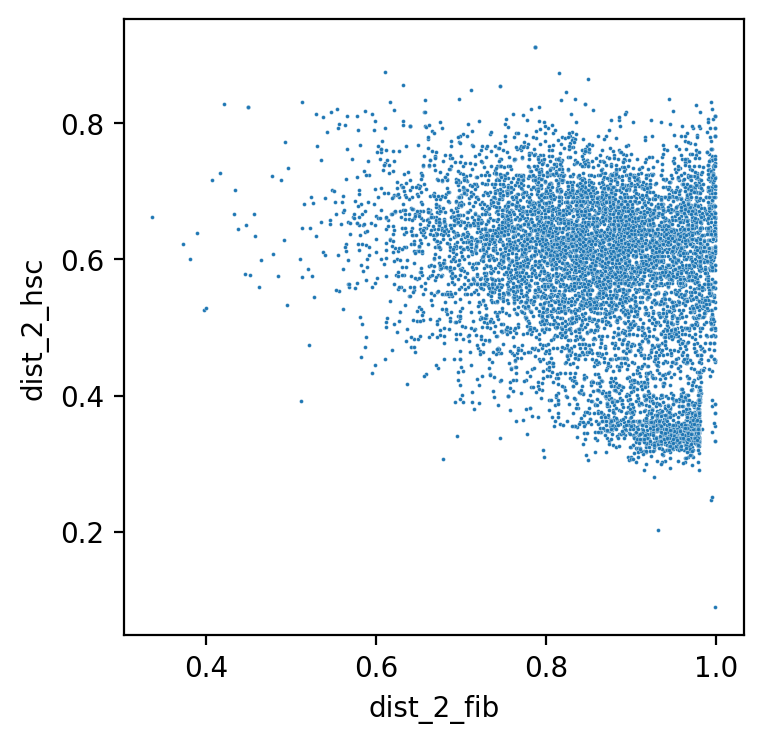

In [74]:
df = pd.concat([
    X.min(axis=1),
    Y.min(axis=1),],
    axis=1,
)

df.columns = ['dist_2_hsc', 'dist_2_fib', ]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=df,
    x='dist_2_fib',
    y='dist_2_hsc',
    s=2,
)

In [ ]:
break

# iHSC to HSC

In [ ]:
common_genes = get_common_genes(
    [hsc_data.var_names,
     ihsc_data.var_names,],
     min_count=2
)

A = reprocess(ihsc_data, common_genes)
B = reprocess(hsc_data, common_genes)

X = get_distance(A, B)
print(f"{X.shape=}")

min_dist = X.min(axis=1)

sns.histplot(
    x=min_dist,
    bins=31,
)

plt.axvline(min_dist.mean(), c='r')

In [ ]:
break